<h1><strong><u>Naive Bayes Test (A4)</u></strong><h1>

In [25]:
import matplotlib.pyplot as plt            
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, ComplementNB
from sklearn.model_selection import cross_val_score, learning_curve, validation_curve
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score, PrecisionRecallDisplay, accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as ImbLearn_Pipeline

<h2><u>Data Loading and Preprocessing</u></h2>

In [26]:
pd.read_csv("./SMSSpamCollection.txt", sep="\t", header=None).to_csv("sms_spam_collection.csv", index=False, header=["target", "message"])

In [27]:
data = pd.read_csv("sms_spam_collection.csv")
data

,target,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [28]:
X = data['message']
y = data["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)
display(X_train.shape) 
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(4457,)

(1115,)

(4457,)

(1115,)

In [29]:
#Display message counts
hams = data[(data['target'] == 'ham')]
spams = data[(data['target'] == 'spam')]
hams_count = hams.value_counts().sum()
spams_count = spams.value_counts().sum()
total_messages = hams_count + spams_count
spam_fraction = spams_count / total_messages

print("Number of ham messages: ", hams_count)
print("Number of spam messages: ", spams_count)
print("Fraction of spam messages: {:.2f}%".format(spam_fraction * 100))

Number of ham messages:  4825
Number of spam messages:  747
Fraction of spam messages: 13.41%


In [30]:
def custom_tokenizer(text):
        from nltk.tokenize import word_tokenize
        from nltk.corpus import stopwords
        from nltk.stem import WordNetLemmatizer
        import re
        en_stopwords = stopwords.words('english')
        lemmatizer = WordNetLemmatizer()
        new_text = text.lower() #lowercase

        new_text = re.sub(r"([^\w\s])", "", new_text) #remove punctuation

        for word in new_text.split(): #remove stopwords
            if word in en_stopwords:
                new_text = new_text.replace(word, "")
        
        new_text = word_tokenize(new_text) #tokenize

        new_text = [lemmatizer.lemmatize(token) for token in new_text] #lemmatize
        return new_text

In [31]:
label_encoder = LabelEncoder()
y_train_transformed = label_encoder.fit_transform(y_train)
y_test_transformed = label_encoder.transform(y_test)

y_train_transformed = pd.Series(data=y_train_transformed, name='target')
y_test_transformed = pd.Series(data=y_test_transformed, name='target')


y_train_transformed_rev = y_train_transformed.replace(to_replace=0, value=2)
y_train_transformed_rev.replace(to_replace=1, value=0, inplace=True)
y_train_transformed_rev.replace(to_replace=2, value=1, inplace=True)

y_test_transformed_rev = y_test_transformed.replace(to_replace=0, value=2)
y_test_transformed_rev.replace(to_replace=1, value=0, inplace=True)
y_test_transformed_rev.replace(to_replace=2, value=1, inplace=True)

<h2><strong><u>Bayesian Model Selection</u></strong><h2>

<h3><u>Validation Curve Tests</u></h3>

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ....................................clf__alpha=0.01; total time=   2.6s
[CV] END ......................................clf__alpha=10; total time=   2.7s
[CV] END ..................................clf__alpha=0.0001; total time=   2.7s
[CV] END .......................................clf__alpha=1; total time=   2.7s
[CV] END .....................................clf__alpha=0.1; total time=   2.7s
[CV] END ...................................clf__alpha=0.001; total time=   2.7s
[CV] END ..................................clf__alpha=0.0001; total time=   2.7s
[CV] END ...................................clf__alpha=0.001; total time=   2.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    7.8s remaining:    7.8s


[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.8s
[CV] END ...................................clf__alpha=0.001; total time=   0.8s
[CV] END .....................................clf__alpha=0.1; total time=   0.8s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END .......................................clf__alpha=1; total time=   0.8s
[CV] END ......................................clf__alpha=10; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.1s finished


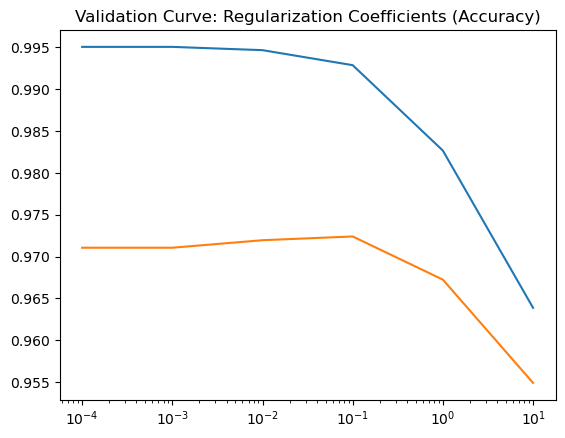

In [32]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train, cv=5, scoring='accuracy',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Accuracy)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.2s remaining:    2.2s


[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.5s
[CV] END .....................................clf__alpha=0.1; total time=   0.5s
[CV] END ....................................clf__alpha=0.01; total time=   0.5s
[CV] END .......................................clf__alpha=1; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.1s finished


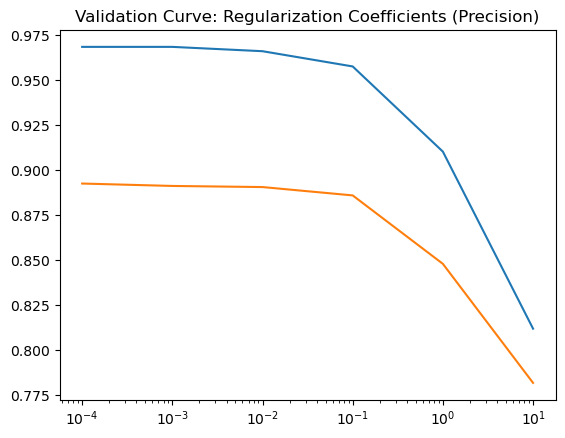

In [33]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed, cv=5, scoring='precision',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Precision)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.5s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.2s remaining:    2.2s


[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.5s
[CV] END ..................................clf__alpha=0.0001; total time=   0.5s
[CV] END ....................................clf__alpha=0.01; total time=   0.5s
[CV] END .....................................clf__alpha=0.1; total time=   0.5s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.2s finished


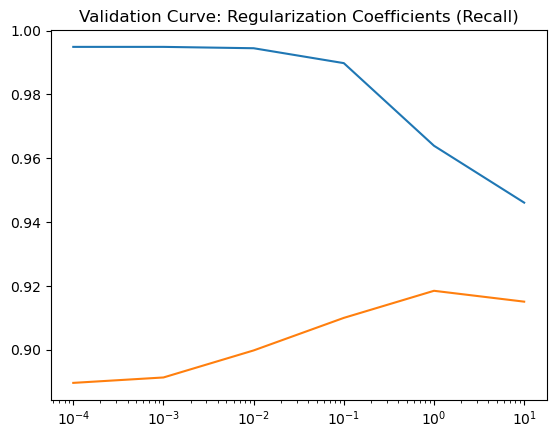

In [34]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed, cv=5, scoring='recall',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Recall)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ....................................clf__alpha=0.01; total time=   0.9s
[CV] END .....................................clf__alpha=0.1; total time=   0.9s
[CV] END ......................................clf__alpha=10; total time=   0.9s
[CV] END .......................................clf__alpha=1; total time=   0.9s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.8s remaining:    2.8s


[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ...................................clf__alpha=0.001; total time=   0.8s
[CV] END .......................................clf__alpha=1; total time=   0.8s
[CV] END .....................................clf__alpha=0.1; total time=   0.8s
[CV] END ......................................clf__alpha=10; total time=   0.8s
[CV] END ....................................clf__alpha=0.01; total time=   0.8s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    5.1s finished


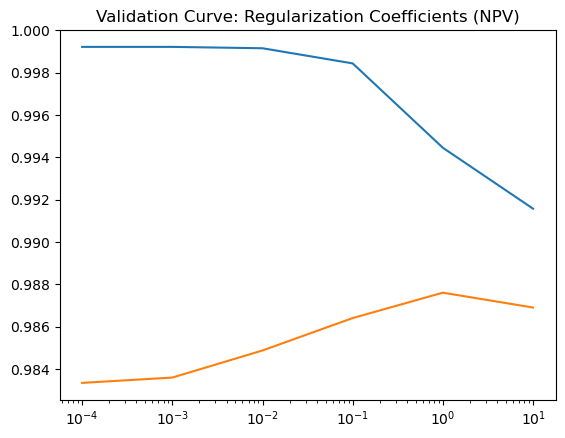

In [35]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed_rev, cv=5, scoring='precision',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (NPV)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.7s
[CV] END .....................................clf__alpha=0.1; total time=   0.7s
[CV] END .......................................clf__alpha=1; total time=   0.7s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  15 out of  30 | elapsed:    2.5s remaining:    2.5s


[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.6s
[CV] END ...................................clf__alpha=0.001; total time=   0.6s
[CV] END ..................................clf__alpha=0.0001; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END .....................................clf__alpha=0.1; total time=   0.6s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ......................................clf__alpha=10; total time=   0.7s
[CV] END ..................................clf__alpha=0.0001; total time=   0.5s
[CV] END .....................................clf__alpha=0.1; total time=   0.5s
[CV] END ...................................clf__alpha=0.001; total time=   0.5s
[CV] END .......................................clf__alpha=1; total time=   0.6s
[CV] END ...................

[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    4.4s finished


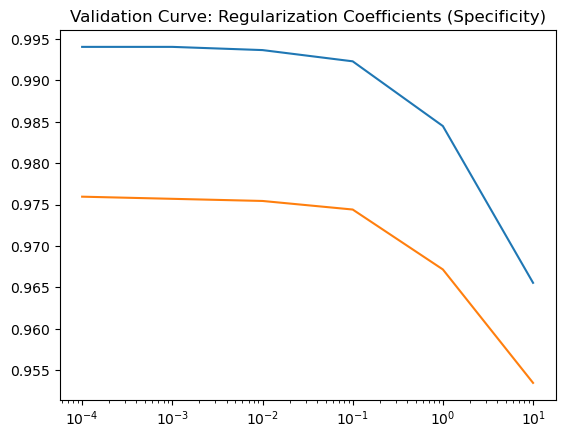

In [36]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 

alphas = [0.0001, 0.001, 0.01, 0.1, 1, 10]
train_scores, validation_scores = validation_curve(pipeline, X_train, y_train_transformed_rev, cv=5, scoring='recall',
                                                   param_name="clf__alpha",
                                                   param_range=alphas,
                                                   verbose=2,
                                                   n_jobs=-1)
train_scores_mean = np.mean(train_scores, axis=1)
validation_scores_mean = np.mean(validation_scores, axis=1)

plt.title("Validation Curve: Regularization Coefficients (Specificity)")
plt.semilogx(alphas, train_scores_mean)
plt.semilogx(alphas, validation_scores_mean)

<h4><u>Findings From Validation Curve Tests</u></h4>
By switching between the RandomUnderSampler function and SMOTE while using a logarithmic range of regularization coefficients, I found that SMOTE performed better than the RandomUnderSampling function on all metrics excluding recall. The 'Recall' Validation Curve for both sampling functions yielded similar shapes except RandomUnderSampler had a better score of about 5%. For the regularization coefficient, the Validation Curve tests resulted in the best values being in the lowest range for the coefficient. On the other hand, recall in particular did not share that trend. The 'Recall' Validation Curve proceeded to improve as the regularization increased but trended downward after 1. Considering that, I believe the best regularization coefficient range that yields the best results across all of the classifier metrics is 0.1-1. Therefore, the GridSearchCV test will include SMOTE and a range of 0.1-1 for the regularization coefficients.

In [32]:
pipeline = ImbLearn_Pipeline(
    [
        ("vect", CountVectorizer(tokenizer=custom_tokenizer, token_pattern=None, strip_accents='unicode')),
        ("samp", SMOTE(random_state=2)),
        ("clf", MultinomialNB())
    ]
) 
param_grid = {"clf__alpha": [0.0005, 0.005, 0.01, 0.05, 0.1]}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-1, scoring='accuracy', verbose=2)
grid_search.fit(X_train, y_train)
print("Best Parameters: ", grid_search.best_params_)
nb_model = grid_search.best_estimator_
print(nb_model)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] END ..................................clf__alpha=0.0005; total time=   0.6s
[CV] END ..................................clf__alpha=0.0005; total time=   0.6s
[CV] END ..................................clf__alpha=0.0005; total time=   0.6s
[CV] END ..................................clf__alpha=0.0005; total time=   0.6s
[CV] END ..................................clf__alpha=0.0005; total time=   0.6s
[CV] END ...................................clf__alpha=0.005; total time=   0.6s
[CV] END ...................................clf__alpha=0.005; total time=   0.6s
[CV] END ...................................clf__alpha=0.005; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__alpha=0.005; total time=   0.6s
[CV] END ....................................clf__alpha=0.01; total time=   0.6s
[CV] END ...................................clf__

<h3><u>Bayesian Training Learning Curves</u><h3>

In [33]:
clf_metrics = {'precision': 'NPV', 'recall': 'Specificity'}

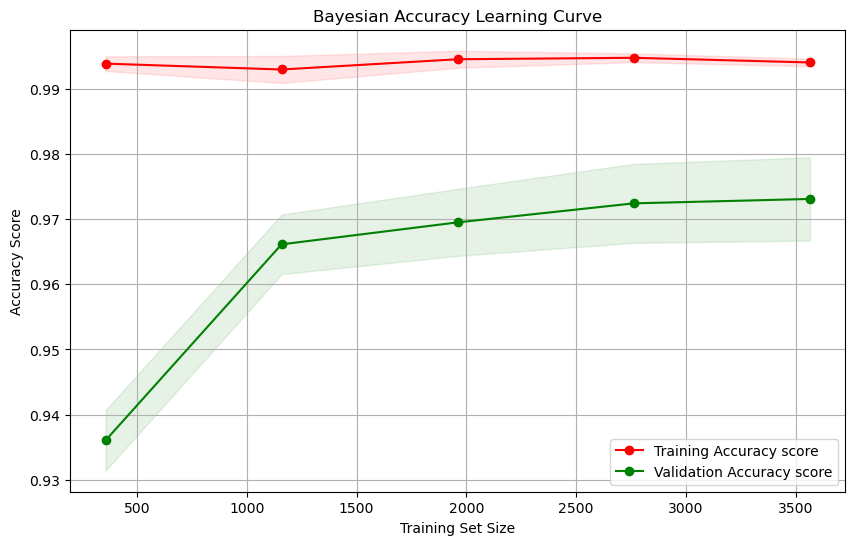

In [34]:
bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
    nb_model,
    X_train,
    y_train,
    cv=5,  # Number of folds for cross-validation
    scoring='accuracy',  # Metric to evaluate the model
    n_jobs=-1,  # Use all available CPU cores
)

# Calculate mean and standard deviation for scores
bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title(f"Bayesian Accuracy Learning Curve")
plt.xlabel("Training Set Size")
plt.ylabel(f"Accuracy Score")
plt.grid()

plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                color="r")
plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                color="g")
plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
            label=f"Training Accuracy score")
plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
            label=f"Validation Accuracy score")

plt.legend(loc="best")
plt.show()

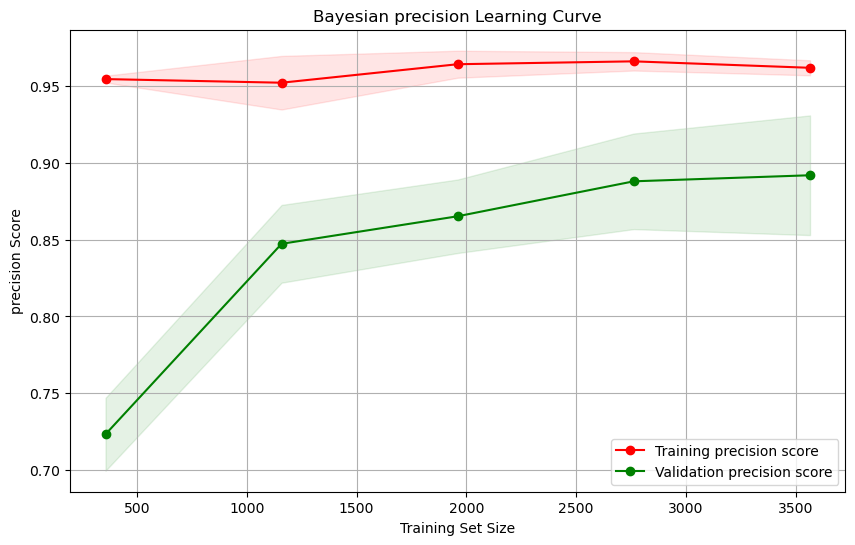

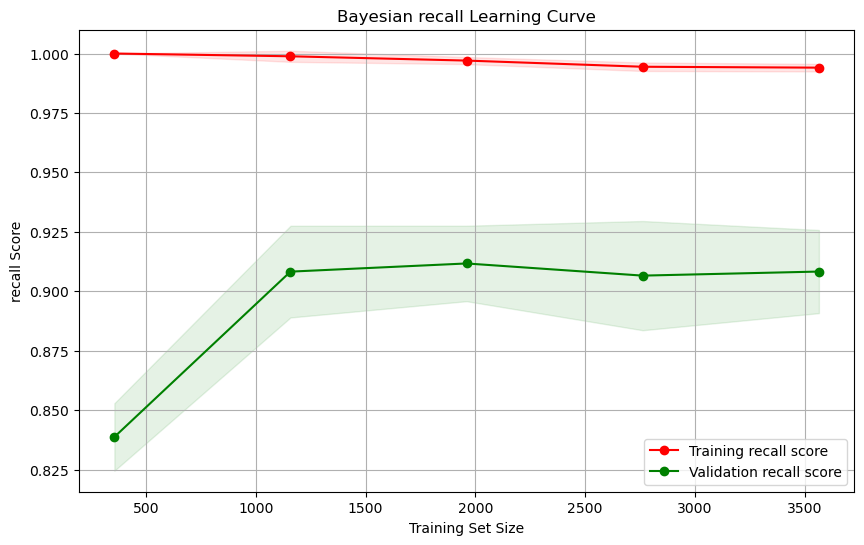

In [35]:
for key in clf_metrics:
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train_transformed,
        cv=5,  # Number of folds for cross-validation
        scoring=key,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {key} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{key} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                    bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
                label=f"Training {key} score")
    plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
                label=f"Validation {key} score")

    plt.legend(loc="best")
    plt.show()

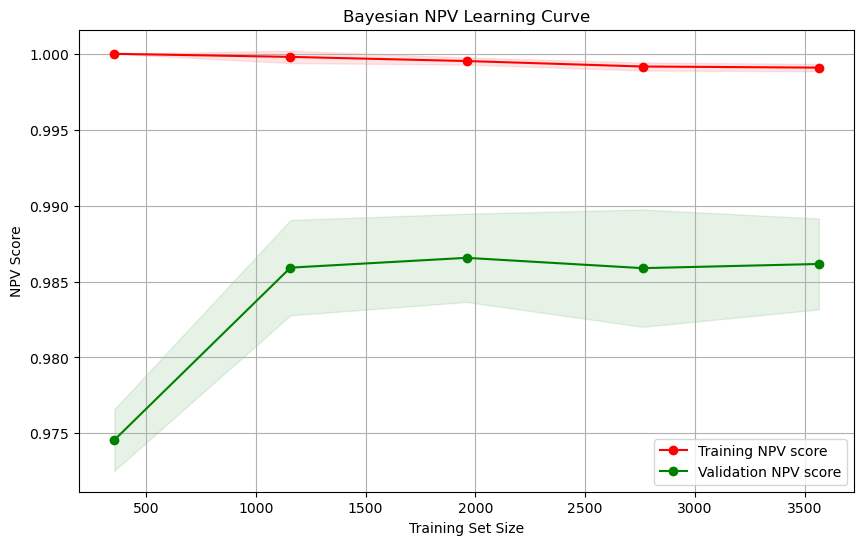

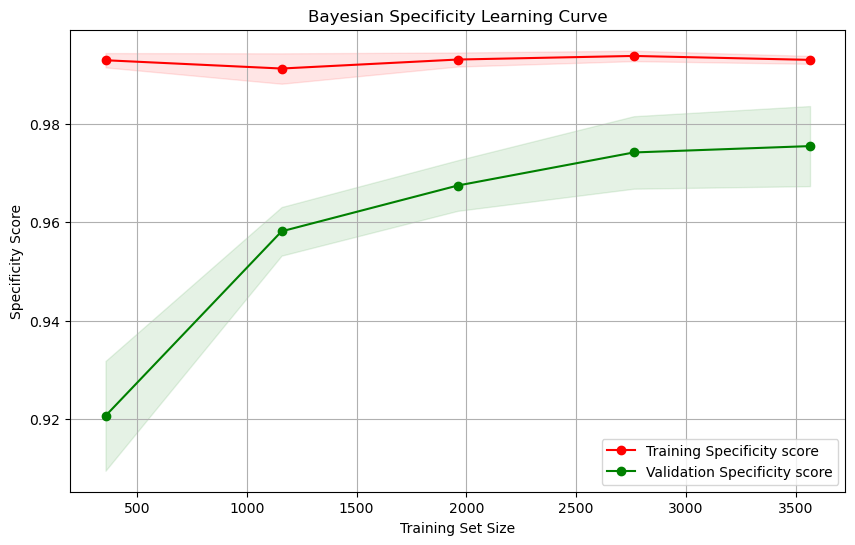

In [36]:
for key, value in clf_metrics.items():
    bayesian_train_sizes, bayesian_train_scores, bayesian_validation_scores = learning_curve(
        nb_model,
        X_train,
        y_train_transformed_rev,
        cv=5,  # Number of folds for cross-validation
        scoring=key,  # Metric to evaluate the model
        n_jobs=-1,  # Use all available CPU cores
    )

    # Calculate mean and standard deviation for scores
    bayesian_train_scores_mean = np.mean(bayesian_train_scores, axis=1)
    bayesian_train_scores_std = np.std(bayesian_train_scores, axis=1)
    bayesian_validation_scores_mean = np.mean(bayesian_validation_scores, axis=1)
    bayesian_validation_scores_std = np.std(bayesian_validation_scores, axis=1)

    # Plot the learning curve
    plt.figure(figsize=(10, 6))
    plt.title(f"Bayesian {value} Learning Curve")
    plt.xlabel("Training Set Size")
    plt.ylabel(f"{value} Score")
    plt.grid()

    plt.fill_between(bayesian_train_sizes, bayesian_train_scores_mean - bayesian_train_scores_std,
                    bayesian_train_scores_mean + bayesian_train_scores_std, alpha=0.1,
                    color="r")
    plt.fill_between(bayesian_train_sizes, bayesian_validation_scores_mean - bayesian_validation_scores_std,
                    bayesian_validation_scores_mean + bayesian_validation_scores_std, alpha=0.1,
                    color="g")
    plt.plot(bayesian_train_sizes, bayesian_train_scores_mean, 'o-', color="r",
                label=f"Training {value} score")
    plt.plot(bayesian_train_sizes, bayesian_validation_scores_mean, 'o-', color="g",
                label=f"Validation {value} score")

    plt.legend(loc="best")
    plt.show()

<h2><strong><u>Metrics</u></strong></h2>

<h3><u>Bayesian Training Results<u></h3>

In [37]:
#Cross-Validation Loop

nb_training_values = cross_val_score(nb_model, X_train, y_train, scoring='accuracy', cv=5)
print("Cross-validation Accuracy training scores: ", nb_training_values)
np_nb_training_values = np.array(nb_training_values)
average = np.mean(np_nb_training_values)
stDev = np.std(np_nb_training_values)
print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation Accuracy training scores:  [0.96412556 0.98318386 0.9708193  0.97530864 0.96969697]
0.97  +/-  0.0064 



In [38]:
for key in clf_metrics:
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train_transformed, scoring=key, cv=5)
    print(f"Cross-validation {key} training scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation precision training scores:  [0.8359375  0.94017094 0.88888889 0.92105263 0.864     ]
0.89  +/-  0.0376 

Cross-validation recall training scores:  [0.90677966 0.93220339 0.88888889 0.88983051 0.91525424]
0.91  +/-  0.0163 



In [39]:
for key, value in clf_metrics.items():
    nb_training_values = cross_val_score(nb_model, X_train, y=y_train_transformed_rev, scoring=key, cv=5)
    print(f"Cross-validation {value} training scores: ", nb_training_values)
    np_nb_training_values = np.array(nb_training_values)
    average = np.mean(np_nb_training_values)
    stDev = np.std(np_nb_training_values)
    print(average.round(2), " +/- ", stDev.round(4), "\n")

Cross-validation NPV training scores:  [0.98546896 0.99089727 0.98316062 0.98311688 0.98680739]
0.99  +/-  0.0029 

Cross-validation Specificity training scores:  [0.96382429 0.98449612 0.98062016 0.97930142 0.96765847]
0.98  +/-  0.008 



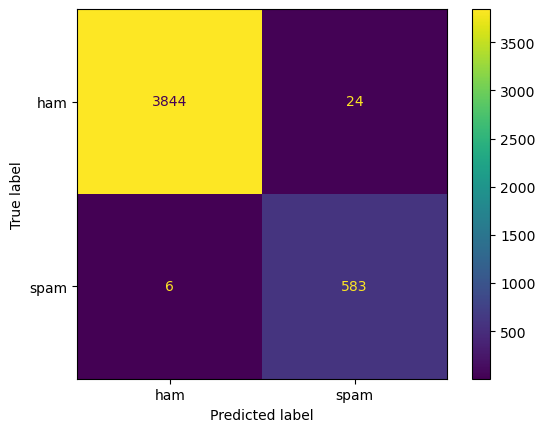

In [40]:
#Training Confusion Matrix
ConfusionMatrixDisplay.from_estimator(nb_model, X_train, y_train)

In [41]:
train_predictions = nb_model.predict(X_train)
nb_train_precision = precision_score(y_train, train_predictions, pos_label='spam')
print("Naive Bayes Training Precision: {:.2f}%".format(nb_train_precision * 100))

nb_train_recall = recall_score(y_train, train_predictions, pos_label='spam')
print("Naive Bayes Training Recall: {:.2f}%".format(nb_train_recall * 100))

nb_train_npv = precision_score(y_train, train_predictions, pos_label='ham')
print("Naive Bayes Negative Predictive Value Training Score: {:.2f}%".format(nb_train_npv * 100))

nb_train_specificity = recall_score(y_train, train_predictions, pos_label='ham')
print("Naive Bayes Specificity Training Score: {:.2f}%".format(nb_train_specificity * 100))

Naive Bayes Training Precision: 96.05%
Naive Bayes Training Recall: 98.98%
Naive Bayes Negative Predictive Value Training Score: 99.84%
Naive Bayes Specificity Training Score: 99.38%


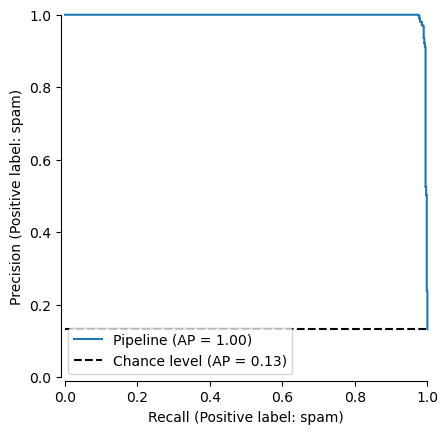

In [42]:
PrecisionRecallDisplay.from_estimator(nb_model, X_train, y_train, pos_label="spam", plot_chance_level=True, despine=True)

<h3><u>Bayesian Testing Results</u></h3>

In [43]:
test_predictions = nb_model.predict(X_test)

nb_test_accuracy = accuracy_score(y_test, test_predictions)
print("Naive Bayes Test Accuracy: {:.2f}%".format(nb_test_accuracy * 100))

nb_test_precision = precision_score(y_test, test_predictions, pos_label='spam')
print("Naive Bayes Test Precision: {:.2f}%".format(nb_test_precision * 100))

nb_test_recall = recall_score(y_test, test_predictions, pos_label='spam')
print("Naive Bayes Test Recall: {:.2f}%".format(nb_test_recall * 100))

nb_test_npv = precision_score(y_test, test_predictions, pos_label='ham')
print("Naive Bayes Negative Predictive Value Test Score: {:.2f}%".format(nb_test_npv * 100))

nb_test_specificity = recall_score(y_test, test_predictions, pos_label='ham')
print("Naive Bayes Specificity Test Score: {:.2f}%".format(nb_test_specificity * 100))

Naive Bayes Test Accuracy: 96.32%
Naive Bayes Test Precision: 88.74%
Naive Bayes Test Recall: 84.81%
Naive Bayes Negative Predictive Value Test Score: 97.51%
Naive Bayes Specificity Test Score: 98.22%


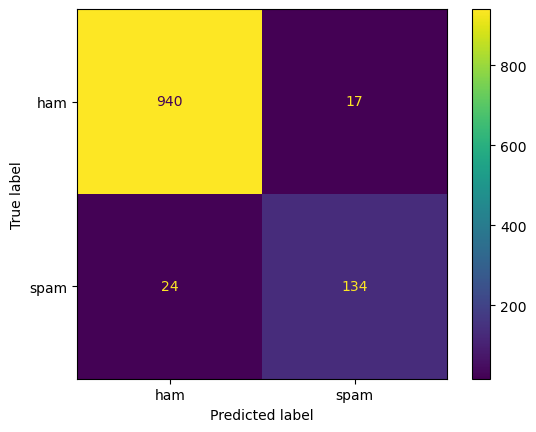

Exception ignored in: <function ResourceTracker.__del__ at 0x10701dbc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1069d9bc0>
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/opt/anaconda3/lib/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x1024bdbc0>
Traceback (most recent call last

In [44]:
#Testing Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, test_predictions)